**EfficientNetB5 Training and Evaluation**

    No of Epochs : 3    [Used lr_find() to find the best learning rate and Data Augmentation on training dataset]

    Top K Accuracy : 0.960528  
    Validation Accuracy : 0.853201 

In [ ]:
# cheking the number of cored this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

# GPU info
!nvidia-smi

# Amount of system RAM available to be used.
from psutil import virtual_memory
ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

#finding the recursion limit to avoid Augmentation recursion error 
import sys
print(sys.getrecursionlimit())

#installing fastai
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

cpu cores	: 2
Thu May 13 04:22:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate

Mounted at /content/drive
1000


In [ ]:
#Installing the pytorch Implementation of EfficientNet 
!pip install --upgrade efficientnet-pytorch

from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=fb4abf01757d95541303aa0e570596ff7d461aa45bc2d9c4b8cc2af0553a2d82
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Data Download 
path = untar_data(URLs.FOOD)

train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path) #Training dataset from Train.txt
test_df = filelist2df(test_path)   #Test dataset from Test.txt

#DataAugmentation on the Training set 
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [ ]:
#Fixing the seeding to fix the randomness in splitting the validation dataset 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
#Performance Evaluation 
def evaluate_performance(y_true, y_predict):
  """
    y_true    : True labels of the Images in test dataset 
    y_predict : Predicted labels of the images in test dataset 

    prints the Confusion Matrix , No.Of Misclassifications, Recall and Food class with maximum and minimum accuracy 

    Used for performance evaluation of any true and predicted labels
  """
  #For classification report 
  import sklearn.metrics as metrics
  print(f"{metrics.classification_report(y_true.items, y_predict)}\n")

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  #Confusion Matrix 
  cm1 = confusion_matrix(y_true.items,y_predict)
  print(cm1)

  print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
  print("No.of misclassified samples ", len(y_predict)-sum(cm1.diagonal()))

  #Calculating the True Occurences
  true_occ= []
  for i in range(len(cm1)):
    true_occ.append(sum(cm1[:,i]))

  #Calculating the recall for all the categories
  dia = cm1.diagonal()
  prediction_prob=[]
  for i in range(len(cm1)):
    tmp_prob = dia[i]/true_occ[i]
    prediction_prob.append(tmp_prob)

  incorrect_class = prediction_prob.index(min(prediction_prob))
  correct_class = prediction_prob.index(max(prediction_prob))
  print("Food category with more no.of correct predictions ",y_true.classes[correct_class] )
  print("Food category with min no.of correct predictions ",y_true.classes[incorrect_class] )

In [ ]:
#checking if the data.valid_dl.y items are the same
def crossverify(data_valid_y):
  """
    data_valid_y : labels of the Validation dataset 
    Returns a Boolean value if the validation dataset has the same labels 

    Expecting the same validation data to perform majority vote ensemble
  """
  oop = pd.DataFrame(data_valid_y.items)
  count_valid = oop.value_counts()
  cat_vd = []
  count_vd=[]
  for i in range(101):
    cat_vd.append(i)
    count_vd.append(count_valid[i])
  dict_shift = dict(zip(cat_vd, count_vd))
  count_id = np.array(count_vd)
  if (count_id[0] == 149 and count_id[1]==138 and count_id[2]==150 and count_id[3]==154):
    return True
  else:
    return False

**EfficientNetB5**

In [ ]:
bs_effb5 = 16  #Batchsize 
img_size_effb5 = 512  #Image Size 
    
seed_everything(40) #Setting the seed to 40 before creating the data bunch 

In [ ]:
#Creating the databunch with data augmentation for training data  
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=img_size_effb5)
        .databunch(bs=bs_effb5)
        .normalize(imagenet_stats))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 6.92E-03


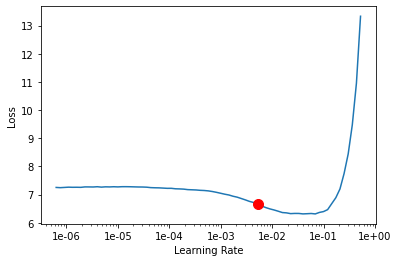

In [ ]:
if crossverify(data.valid_dl.y):
  #Loading the EfficientNet Model    
  model = EfficientNet.from_pretrained("efficientnet-b5")   
  top_5 = partial(top_k_accuracy, k=5)
  #Initializing the fastai learner 
  learneffb5 = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learneffb5.split( lambda m: (model._conv_head,) )
  #Finding the best learning rate using lr_find()
  learneffb5.lr_find()
  learneffb5.recorder.plot(suggestion=True)
else:
  print("Data Mismatch")

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.867954,1.267833,0.682772,0.894125,1:19:55
1,1.217065,0.784500,0.807987,0.948581,1:19:54
2,0.837500,0.595656,0.853201,0.960528,1:19:59


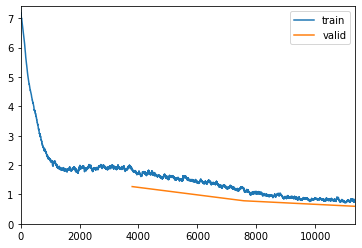

NameError: ignored

In [ ]:
lr = 4e-3 #setting the learning rate 
learneffb5.fit_one_cycle(3,max_lr=slice(lr)) #Training the model for 3 epochs

In [ ]:
#Saving the model for ensembling 
learneffb5.save('/content/drive/MyDrive/food101-effNetb5-train-e3') 

In [ ]:
#Prediction for the vaidation dataset 
if crossverify(data.valid_dl.y):
  start= time.time()
  Y_valid_predict_effb5 = []
  for img in data.valid_dl.x:
      tmp_predict = learneffb5.predict(img) 
      Y_valid_predict_effb5.append(tmp_predict[1]) #predict will return three tensor values along with the probability for each category. Extracting only the predicted label
  end = time.time()
  print('Time taken to predict for EfficientNetb3  :',{end - start})
else:
  print('Data Mismatch')

evaluate_performance(data.valid_dl.y,Y_valid_predict_effb5)

Time taken to predict for EfficientNetb3  : {905.0052115917206}
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       149
           1       0.80      0.83      0.81       138
           2       0.87      0.88      0.87       150
           3       0.88      0.92      0.90       154
           4       0.80      0.89      0.84       141
           5       0.82      0.81      0.81       159
           6       0.82      0.89      0.85       133
           7       0.85      0.95      0.90       136
           8       0.73      0.72      0.73       164
           9       0.79      0.83      0.81       136
          10       0.80      0.78      0.79       143
          11       0.91      0.88      0.90       145
          12       0.91      0.89      0.90       157
          13       0.87      0.91      0.89       148
          14       0.84      0.74      0.79       149
          15       0.77      0.74      0.76       148
          16     

In [ ]:
# Applying TestTime Augmentation and finding the test accuracy 
test_data=(ImageList.from_df(df=test_df,path=path/'images',cols=1)
      .split_none()
      .label_from_df(cols=0)
      .transform(ds_tfms,size=img_size_effb5)
      .databunch(bs=bs_effb5)
      .normalize(imagenet_stats))

top_5 = partial(top_k_accuracy,k=5)
learneffb5 = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16() #by default float 32 training in 16 bits..takes only half the size. 
learneffb5.load('/content/drive/MyDrive/food101-effNetb5-train-e3')

learneffb5.validate(test_data.train_dl)

In [ ]:
test_pred, y = learn.TTA(ds_type=test_data.train_dl)
accuracy(test_pred, y)